In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
data1 = pd.read_csv('/content/drive/Shareddrives/MSBA Capstone Sharing/2. Data/230607 Events dump.csv')
#data = pd.read_csv('/content/drive/Shareddrives/BA888-Capstone-SponsorMotion/230607 Events dump-reduced.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-36cbffe66ade>:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('/content/drive/Shareddrives/MSBA Capstone Sharing/2. Data/230607 Events dump.csv')


In [7]:
data1=data1.dropna(subset=['summary'])
data1.shape

(45498, 21)

In [9]:
data1.head()

,country,end date,flagged_by,has_embedding,human verification,is virtual,is_flagged,is_free,location,name,...,specialties,start date,state,summary,URL,Creation Date,Modified Date,Slug,Creator,unique id
0,US,"Mar 28, 2023 12:00 am",NaN,yes,Verified - OK,NaN,NaN,NaN,"Tampa, FL, USA",SGO Annual Meeting on Women’s Cancer,...,"Medicine , Hematology and Oncology , Obstetric...","Mar 25, 2023 12:00 am",FL,The SGO Annual Meeting on Women’s Cancer® is t...,NaN,"Mar 29, 2023 4:08 pm","May 8, 2023 10:12 am",NaN,paolo@sponsormotion.com,1680120526987x888446806284079400
1,US,"Nov 4, 2022 12:00 am",NaN,yes,Verified - OK,NaN,NaN,NaN,"University Technology Center II, 3650 Spectrum...",FAPTP's 45th Annual Seminar,...,"Medicine , Hematology and Oncology , Pediatric...","Nov 3, 2022 12:00 am",FL,"FAPTP's 45th Annual Seminar, 'Advances in Pedi...",NaN,"Mar 29, 2023 4:08 pm","May 3, 2023 6:29 pm",NaN,paolo@sponsormotion.com,1680120530555x259893486984035460
2,US,"Apr 19, 2023 12:00 am",NaN,yes,Verified - OK,NaN,NaN,NaN,"9800 International Dr, Orlando, FL 32819, USA",AACR Annual Meeting 2023,...,"Medicine , Hematology and Oncology , Internal ...","Apr 14, 2023 12:00 am",FL,The AACR Annual Meeting is the focal point of ...,NaN,"Mar 29, 2023 4:08 pm","May 8, 2023 10:13 am",NaN,paolo@sponsormotion.com,1680120536478x149218014932820380
3,US,"Jul 29, 2023 12:00 am",NaN,yes,Verified - Duplicate,NaN,NaN,NaN,"Amelia Island, Florida 32034, USA",32nd Annual Mayo Clinic Hematology/Oncology Re...,...,"Medicine , Hematology and Oncology , Hematolog...","Jul 27, 2023 12:00 am",FL,Mayo Clinic's 32nd Annual Hematology/Oncology ...,NaN,"Mar 29, 2023 4:08 pm","May 3, 2023 6:29 pm",NaN,paolo@sponsormotion.com,1680120538716x333574781569262660
4,US,"Sep 1, 2022 12:00 am",NaN,yes,Verified - OK,NaN,NaN,NaN,"Florida, USA",FCDS 2022 Virtual Annual Conference,...,"Medicine , Internal medicine","Aug 11, 2022 12:00 am",FL,The FCDS 2022 Virtual Annual Conference will c...,NaN,"Mar 29, 2023 4:09 pm","May 3, 2023 6:29 pm",NaN,paolo@sponsormotion.com,1680120546628x698788135365455200


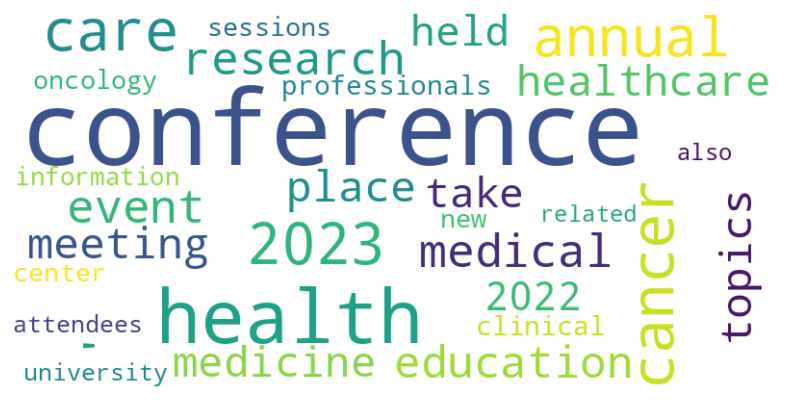

In [10]:
#We already found the most common words occuring in the summary column so using the words and their frequency here is the wordcloud of these words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word frequency dictionary
word_freq = {'conference': 2943, 'health': 1252, 'cancer': 730, '2023': 717, 'care': 694, 'annual': 649,
             'medical': 444, 'research': 435, 'event': 434, 'education': 400, 'meeting': 381, 'topics': 379,
             'place': 378, 'medicine': 361, 'healthcare': 354, "'": 350, 'held': 332, 'take': 325,
             '2022': 314, 'professionals': 313, 'clinical': 310, 'sessions': 298, 'center': 293, 'new': 287,
             'oncology': 284, 'information': 263, 'attendees': 245, 'university': 245, 'also': 233,
             'related': 233}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
# Randomly select 5000 rows
random_rows = data1.sample(n=5000, random_state=42)  # Set a random_state for reproducibility

# Create a new dataframe with the selected rows
data = pd.DataFrame(random_rows)

# Optional: Reset the index of the new dataframe if desired
data = data.reset_index(drop=True)
data.shape

(5000, 21)

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Create a dictionary to store event summaries for each state
state_buckets = {}
missing_state_bucket = []  # Create a bucket for events with blank states

# Iterate over the rows and populate the state buckets
for index, row in data.iterrows():
    state = row['state']
    summary = row['summary']

    if pd.isnull(state):
        missing_state_bucket.append(summary)
    else:
        if state not in state_buckets:
            state_buckets[state] = []
        state_buckets[state].append(summary)

# Initialize an empty list to store duplicate event pairs
duplicate_pairs = []

# Preprocess the summaries by excluding certain words
exclude_words = ['conference', 'health', 'care', 'annual', 'medical', 'research', 'event', 'education',
                  'meeting', 'topics', 'place', 'medicine', 'healthcare', '’', 'held', 'take', 'professionals',
                  'clinical', 'sessions', 'center', 'new', 'oncology', 'information', 'attendees', 'university',
                  'also', 'related']  # Words to be excluded

# Iterate over the state buckets and calculate cosine similarity for each state
for state, summaries in state_buckets.items():
    # Preprocess summaries by excluding certain words
    processed_summaries = []
    for summary in summaries:
        words = summary.split()
        processed_words = [word for word in words if word.lower() not in exclude_words]
        processed_summary = ' '.join(processed_words)
        processed_summaries.append(processed_summary)

    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Generate TF-IDF matrix for the processed summaries within the state
    tfidf_matrix = vectorizer.fit_transform(processed_summaries)

    # Calculate cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Set a threshold for similarity within the state
    similarity_threshold = 0.8

    # Find duplicates and add them to the duplicate_pairs list
    for i in range(len(cosine_sim_matrix)):
        for j in range(i + 1, len(cosine_sim_matrix)):
            if cosine_sim_matrix[i, j] > similarity_threshold:
                duplicate_pairs.append((i, j))

# Flag duplicates in the original dataset
data['is_duplicate'] = 0
for pair in duplicate_pairs:
    data.at[pair[0], 'is_duplicate'] = 1
    data.at[pair[1], 'is_duplicate'] = 1

# Save the updated dataset with duplicate flags
data.to_csv('updated_dataset.csv', index=False)


In [14]:
data['is_duplicate'].value_counts()

0    4931
1      69
Name: is_duplicate, dtype: int64

In [ ]:
from google.colab import files
files.download('updated_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>